Kelompok F : 

1. Alya Nadifa Putri (1806144342)
2. Kinanti Jati Kinasih (1806144456)
3. Ni Gusti Ayu Nyoman Anggraini L. (1806193350)
4. Dian Karyoko (1806193735)
5. Andi Renata Fadhillah (1806207841)
6. Muhamad Alchem Nuravian Permana (1806207873)
7. Anastasia Juniaty (1806208251)
8. Gilang Laksana Prawira (1806232124) 
 

Sumber data : https://www.kaggle.com/c/ashrae-energy-prediction/data

Problem : Apakah investment yang dilakukan untuk meningkatkan efisiensi gedung benar-benar efektif atau tidak (dapat mengurangi cost dan emission)?

Untuk mencari tahu hal tersebut, akan dibandingkan pemakaian energi sebelum dan sesudah efisiensi. Akan tetapi, karena pemakaian energi sebelum efisiensi tidak diketahui, dibutuhkan model yang dapat memprediksi banyaknya energi yang digunakan (diwakilkan dengan variabel meter_reading) sebelum efisiensi gedung dilakukan. 

Dalam tugas ini akan dilakukan EDA untuk melihat variabel-variabel yang mungkin memengaruhi variabel meter_reading. Data diambil dari 1449 gedung di Amerika Serikat, Inggris, Kanada, dan lain-lain.

**Objective : Mencari tahu variabel-variabel yang memengaruhi meter_reading dan mendapatkan insight sebanyak-banyaknya**

In [1]:
#Import package yang dibutuhkan

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Download data dan unzip file

from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='10yM8r4UMFYr5ugb4vcpCWDanVUxEGkII',
                                    dest_path='./ashrae-energy-prediction.zip',
                                    unzip = True)

# **Data : building_metadata.csv**

Keterangan :
*   site_id - Foreign key for the weather files
*   building_id - Foreign key for training.csv
*   primary_use - Indicator of the primary category of activities for the building based on EnergyStar property type definitions
*   square_feet - Gross floor area of the building
*   year_built - Year building was opened
*   floor_count - Number of floors of the building

In [3]:
# Mengubah file csv menjadi dataframe

df1 = pd.read_csv('building_metadata.csv')
df1.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   site_id      1449 non-null   int64  
 1   building_id  1449 non-null   int64  
 2   primary_use  1449 non-null   object 
 3   square_feet  1449 non-null   int64  
 4   year_built   675 non-null    float64
 5   floor_count  355 non-null    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 68.0+ KB


In [ ]:
# Mengecek banyak variabel kategorik

df1['primary_use'].value_counts()

Education                        549
Office                           279
Entertainment/public assembly    184
Public services                  156
Lodging/residential              147
Other                             25
Healthcare                        23
Parking                           22
Warehouse/storage                 13
Manufacturing/industrial          12
Retail                            11
Services                          10
Technology/science                 6
Food sales and service             5
Utility                            4
Religious worship                  3
Name: primary_use, dtype: int64

# **Data : weather_train.csv**

Keterangan:
*   site_id
*   air_temperature (suhu udara) - Degrees Celsius
*   cloud_coverage (cakupan awan)- Portion of the sky covered in clouds, in oktas 
*   dew_temperature (suhu embun) - Degrees Celsius
*   precip_depth_1_hr (precipitation/banyaknya air dari langit karena sebab apapun) - Millimeters 
*   sea_level_pressure (tekanan permukaan laut) - Millibar/hectopascals
*   wind_direction (arah angin) - Compass direction (0-360)
*   wind_speed (kecepatan angin) - Meters per second

In [4]:
df2 = pd.read_csv('weather_train.csv')
df2.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   site_id             139773 non-null  int64  
 1   timestamp           139773 non-null  object 
 2   air_temperature     139718 non-null  float64
 3   cloud_coverage      70600 non-null   float64
 4   dew_temperature     139660 non-null  float64
 5   precip_depth_1_hr   89484 non-null   float64
 6   sea_level_pressure  129155 non-null  float64
 7   wind_direction      133505 non-null  float64
 8   wind_speed          139469 non-null  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 9.6+ MB


# **Data : train.csv**

Keterangan :
*   building_id - Foreign key for the building metadata
*   meter - The meter id code. Read as {0: electricity, 1: chilledwater, 2: steam, 3: hotwater}. Not every building has all meter types.
*   timestamp - When the measurement was taken
*   meter_reading - The target variable. Energy consumption in kWh (or equivalent). Note that this is real data with measurement error, which we expect will impose a baseline level of modeling error. 

UPDATE: as discussed here, the site 0 electric meter readings are in kBTU.

In [5]:
df3 = pd.read_csv('train.csv')
df3.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0
3,3,0,2016-01-01 00:00:00,0.0
4,4,0,2016-01-01 00:00:00,0.0


In [ ]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 columns):
 #   Column         Dtype  
---  ------         -----  
 0   building_id    int64  
 1   meter          int64  
 2   timestamp      object 
 3   meter_reading  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 616.9+ MB


# **Menggabungkan Ketiga Dataframe**

In [6]:
# Menggabungkan ketiga dataframe

df_total = df3.merge(df1, on='building_id', how='left')
df_total = df_total.merge(df2, on=['site_id','timestamp'], how='left')

df_total.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01 00:00:00,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,1,0,2016-01-01 00:00:00,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
2,2,0,2016-01-01 00:00:00,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
3,3,0,2016-01-01 00:00:00,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
4,4,0,2016-01-01 00:00:00,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0


In [ ]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20216100 entries, 0 to 20216099
Data columns (total 16 columns):
 #   Column              Dtype  
---  ------              -----  
 0   building_id         int64  
 1   meter               int64  
 2   timestamp           object 
 3   meter_reading       float64
 4   site_id             int64  
 5   primary_use         object 
 6   square_feet         int64  
 7   year_built          float64
 8   floor_count         float64
 9   air_temperature     float64
 10  cloud_coverage      float64
 11  dew_temperature     float64
 12  precip_depth_1_hr   float64
 13  sea_level_pressure  float64
 14  wind_direction      float64
 15  wind_speed          float64
dtypes: float64(10), int64(4), object(2)
memory usage: 2.6+ GB


# **Mengganti Tipe Data dan Menambahkan Variabel**

In [7]:
# Mengubah tipe variabel timestamp menjadi datetime

import datetime
from datetime import datetime
df_total['timestamp'] = pd.to_datetime(df_total['timestamp'])

In [8]:
# Menambahkan jam, bulan, nama hari

df_total['hour'] = np.uint8(df_total['timestamp'].dt.hour)
df_total['month'] = np.uint8(df_total['timestamp'].dt.month)
df_total['day_name'] = df_total['timestamp'].dt.day_name()

df_total.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,month,day_name
0,0,0,2016-01-01,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,Friday
1,1,0,2016-01-01,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,Friday
2,2,0,2016-01-01,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,Friday
3,3,0,2016-01-01,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,Friday
4,4,0,2016-01-01,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,0,1,Friday


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


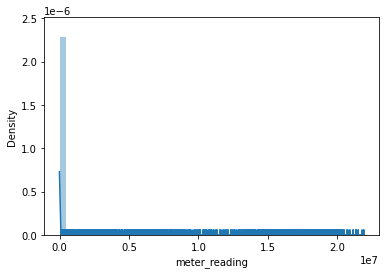

In [ ]:
# Melihat distribusi meter_reading

sns.distplot(df_total['meter_reading'], kde=True, rug=True)

Akan digunakan transformasi log untuk melihat distribusi data meter_reading secara lebih jelas.

In [9]:
# Menambahkan variabel natural_log ke df_total 

df_total['natural_log'] = np.log(df_total['meter_reading']+1)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


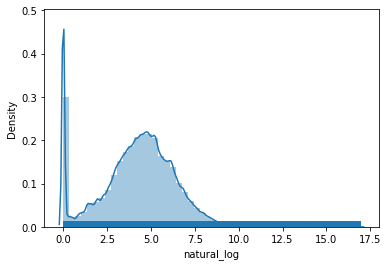

In [ ]:
# Melihat distribusi log(meter_reading)

sns.distplot(df_total['natural_log'], kde=True, rug=True)

Dari plot di atas, dapat terlihat bahwa log(meter_reading) berdistribusi normal (jika mengabaikan missing value).

In [10]:
# Mengubah tipe data

df_total['primary_use'] = df_total['primary_use'].astype('category')
df_total['building_id'] = df_total['building_id'].astype('category')
df_total['site_id'] = df_total['site_id'].astype('category')
df_total['cloud_coverage'] = df_total['cloud_coverage'].astype('category')
df_total['day_name'] = df_total['day_name'].astype('category')
df_total['meter'] = df_total['meter'].astype('category')

df_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20216100 entries, 0 to 20216099
Data columns (total 20 columns):
 #   Column              Dtype         
---  ------              -----         
 0   building_id         category      
 1   meter               category      
 2   timestamp           datetime64[ns]
 3   meter_reading       float64       
 4   site_id             category      
 5   primary_use         category      
 6   square_feet         int64         
 7   year_built          float64       
 8   floor_count         float64       
 9   air_temperature     float64       
 10  cloud_coverage      category      
 11  dew_temperature     float64       
 12  precip_depth_1_hr   float64       
 13  sea_level_pressure  float64       
 14  wind_direction      float64       
 15  wind_speed          float64       
 16  hour                uint8         
 17  month               uint8         
 18  day_name            category      
 19  natural_log         float64       
dtype

# **Data Cleaning : Duplikasi, Noise, Outlier, dan Missing Value**

**Mengecek Duplikasi Data**

In [ ]:
# Mengecek duplikasi data

df_total.duplicated().sum()

0

**Mengecek Noise Data**

In [ ]:
# Mengecek noise (akan dilihat dari nilai min max)

# square_feet tidak boleh negatif 
# air_temperature dan dew_tempature : range sekitar (-20, 40)
# wind_direction : rangenya 0-360
# wind_speed tidak boleh negatif  
# sea_level_pressure : range 950 - 1050 (https://www.e-education.psu.edu/meteo3/l6_p3.html#:~:text=This%20is%20where%20knowing%20the%20typical%20range%20of,or%20an%20extremely%20strong%20Arctic%20high%20in%20winter%29.)
# meter_reading tidak boleh negatif

df_total.describe()

,meter_reading,square_feet,year_built,floor_count,air_temperature,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,month
count,2.021610e+07,2.021610e+07,8.088455e+06,3.506933e+06,2.011944e+07,2.011596e+07,1.646708e+07,1.898443e+07,1.876705e+07,2.007242e+07,2.021610e+07,2.021610e+07
mean,2.117121e+03,1.077830e+05,1.968277e+03,4.184848e+00,1.598795e+01,7.747429e+00,7.964155e-01,1.016085e+03,1.730151e+02,3.377525e+00,1.150232e+01,6.578453e+00
std,1.532356e+05,1.171424e+05,3.020815e+01,4.008277e+00,1.094729e+01,1.017867e+01,7.468997e+00,7.060539e+00,1.140574e+02,2.265694e+00,6.922017e+00,3.436662e+00
min,0.000000e+00,2.830000e+02,1.900000e+03,1.000000e+00,-2.890000e+01,-3.500000e+01,-1.000000e+00,9.682000e+02,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
25%,1.830000e+01,3.252700e+04,1.951000e+03,1.000000e+00,8.600000e+00,0.000000e+00,0.000000e+00,1.011600e+03,7.000000e+01,2.100000e+00,6.000000e+00,4.000000e+00
50%,7.877500e+01,7.270900e+04,1.969000e+03,3.000000e+00,1.670000e+01,8.900000e+00,0.000000e+00,1.016000e+03,1.800000e+02,3.100000e+00,1.200000e+01,7.000000e+00
75%,2.679840e+02,1.391130e+05,1.993000e+03,6.000000e+00,2.410000e+01,1.610000e+01,0.000000e+00,1.020500e+03,2.800000e+02,4.600000e+00,1.800000e+01,1.000000e+01
max,2.190470e+07,8.750000e+05,2.017000e+03,2.600000e+01,4.720000e+01,2.610000e+01,3.430000e+02,1.045500e+03,3.600000e+02,1.900000e+01,2.300000e+01,1.200000e+01


**Mengecek Outlier**

Selanjutnya akan dilakukan deteksi *outlier*. Deteksi *outlier* dilakukan terlebih dahulu sebelum imputasi *missing value* agar *outlier* tidak memengaruhi metode imputasi. Deteksi *outlier* akan dilakukan dengan metode *interquartile*. Metode ini dipilih karena penggunaannya yang praktis dan tidak membutuhkan banyak asumsi (non-parametrik).

Akan tetapi, metode interquartile tidak dapat diterapkan pada variabel precip_depth_1_hr, karena Q1=Q2=Q3=0. Oleh karena itu, sebelum melakukan deteksi dan menyingkirkan outlier, akan dilihat banyaknya *zero values* di variabel precip_depth_1_hr.

In [12]:
# Mengecek banyaknya zero values di variabel precip_depth_1_hr

df_total['precip_depth_1_hr'].isin([0]).sum()

14517573

Walaupun banyak pengamatan yang berisi *zero values* pada variabel precip_depth_1_hr, tetapi nilai 0 untuk variabel tersebut masih masuk akal, sehingga tidak akan kita kategorikan sebagai *missing value*. Metode interquartile tidak akan diterapkan pada variabel ini agar nilai-nilai tidak 0 tetap terjaga.

In [13]:
# Meremove outlier meter_reading

Q1 = df_total['meter_reading'].quantile(0.25)
Q3 = df_total['meter_reading'].quantile(0.75)
IQR = Q3 - Q1
df_total.drop(df_total[(df_total.meter_reading < (Q1-1.5*IQR)) | (df_total.meter_reading > (Q3+1.5*IQR))].index, inplace = True)

In [14]:
# Meremove outlier square_feet

Q1 = df1['square_feet'].quantile(0.25)
Q3 = df1['square_feet'].quantile(0.75)
IQR = Q3 - Q1
df_total.drop(df_total[(df_total.square_feet < (Q1-1.5*IQR)) | (df_total.square_feet > (Q3+1.5*IQR))].index, inplace = True)

In [15]:
# Meremove outlier air_temperature

Q1 = df2['air_temperature'].quantile(0.25)
Q3 = df2['air_temperature'].quantile(0.75)
IQR = Q3 - Q1
df_total.drop(df_total[(df_total.air_temperature < (Q1-1.5*IQR)) | (df_total.air_temperature > (Q3+1.5*IQR))].index, inplace = True)

In [16]:
# Meremove outlier dew_temperature

Q1 = df2['dew_temperature'].quantile(0.25)
Q3 = df2['dew_temperature'].quantile(0.75)
IQR = Q3 - Q1
df_total.drop(df_total[(df_total.dew_temperature < (Q1-1.5*IQR)) | (df_total.dew_temperature > (Q3+1.5*IQR))].index, inplace = True)

In [17]:
# Meremove outlier sea_level_pressure

Q1 = df2['sea_level_pressure'].quantile(0.25)
Q3 = df2['sea_level_pressure'].quantile(0.75)
IQR = Q3 - Q1
df_total.drop(df_total[(df_total.sea_level_pressure < (Q1-1.5*IQR)) | (df_total.sea_level_pressure > (Q3+1.5*IQR))].index, inplace = True)

In [18]:
# Meremove outlier wind_direction

Q1 = df2['wind_direction'].quantile(0.25)
Q3 = df2['wind_direction'].quantile(0.75)
IQR = Q3 - Q1
df_total.drop(df_total[(df_total.wind_direction < (Q1-1.5*IQR)) | (df_total.wind_direction > (Q3+1.5*IQR))].index, inplace = True)

In [19]:
# Meremove outlier wind_speed

Q1 = df2['wind_speed'].quantile(0.25)
Q3 = df2['wind_speed'].quantile(0.75)
IQR = Q3 - Q1
df_total.drop(df_total[(df_total.wind_speed < (Q1-1.5*IQR)) | (df_total.wind_speed > (Q3+1.5*IQR))].index, inplace = True)

In [20]:
# Melihat banyaknya data setelah outlier diremove

df_total.shape

(16121412, 20)

**Mengecek Missing Value**

In [21]:
# Mengecek missing value

df_total.isnull().sum()

building_id                  0
meter                        0
timestamp                    0
meter_reading                0
site_id                      0
primary_use                  0
square_feet                  0
year_built             9535865
floor_count           13155706
air_temperature          80047
cloud_coverage         6901287
dew_temperature          82490
precip_depth_1_hr      3100434
sea_level_pressure     1105853
wind_direction         1165071
wind_speed              117737
hour                         0
month                        0
day_name                     0
natural_log                  0
dtype: int64

Karena floor_count memiliki missing value >80% dan variabel year_built memiliki missing value >50%, maka kedua variabel tersebut akan di drop.

In [22]:
df_total.drop(labels = 'year_built', axis = 1, inplace = True)

In [23]:
df_total.drop(labels = 'floor_count', axis = 1, inplace = True)

Salah satu cara yang paling mudah dan umum digunakan untuk me-*replace missing value* adalah menggantinya dengan *mean* atau median. Akan tetapi, karena data ini adalah data runtun waktu, mengganti *missing value* dengan *mean* atau median akan menjadi kurang akurat, terlebih jika data tersebut tidak stasioner. 

Oleh karena itu, kami akan menggunakan metode interpolasi linier untuk me-*replace* data yang hilang. Metode interpolasi linier digunakan karena ekonomis (algoritmanya tidak terlalu rumit), efisien, dan terbukti memiliki performa lebih baik daripada interpolasi non-linier di kebanyakan kasus untuk memprediksi *missing value* (Gnauk, 2004). 

In [25]:
# Mengganti missing value pada variabel numerik dengan interpolasi linier

df_total['air_temperature'].interpolate(method='linear', direction = 'both', inplace = True)
df_total['dew_temperature'].interpolate(method='linear', direction = 'both', inplace = True)
df_total['precip_depth_1_hr'].interpolate(method='linear', direction = 'both', inplace = True)
df_total['sea_level_pressure'].interpolate(method='linear', direction = 'both', inplace = True)
df_total['wind_direction'].interpolate(method='linear', direction = 'both', inplace = True)
df_total['wind_speed'].interpolate(method='linear', direction = 'both', inplace = True)

In [26]:
# Mengganti missing value di cloud_coverage dengan modus
df_total['cloud_coverage'] = df_total['cloud_coverage'].fillna(df_total['cloud_coverage'].mode()[0])

In [27]:
# Mengecek jumlah missing value setelah melakukan imputasi

df_total.isnull().sum()

building_id              0
meter                    0
timestamp                0
meter_reading            0
site_id                  0
primary_use              0
square_feet              0
air_temperature          0
cloud_coverage           0
dew_temperature          0
precip_depth_1_hr     1933
sea_level_pressure       0
wind_direction           0
wind_speed               0
hour                     0
month                    0
day_name                 0
natural_log              0
dtype: int64

In [28]:
# Menghitung persentase missing value

1933/16121412

0.0001199026487258064

Karena missing value di variabel precip_depth_1_hr masih ada bahkan setelah dilakukan imputasi, maka row yang memuat missing value tersebut akan di drop. Karena jumlahnya sedikit (hanya 0.0001% dari total seluruh pengamatan), maka hal ini tidak akan terlalu memengaruhi hasil akhir secara keseluruhan, dan data yang tersisa masih cukup representatif.

In [29]:
# Men-drop row dengan missing value

df_total.dropna(inplace = True)

In [30]:
# Memeriksa jumlah missing value setelah imputasi dan drop

df_total.isnull().sum()

building_id           0
meter                 0
timestamp             0
meter_reading         0
site_id               0
primary_use           0
square_feet           0
air_temperature       0
cloud_coverage        0
dew_temperature       0
precip_depth_1_hr     0
sea_level_pressure    0
wind_direction        0
wind_speed            0
hour                  0
month                 0
day_name              0
natural_log           0
dtype: int64

Catatan :
Pada variabel meter_reading, terlihat seolah-olah tidak ada missing value. Akan tetapi, jika diperhatikan lebih lanjut, ada beberapa missing value sebagai berikut:
1.   Data hilang 3-5 bulan pertama (Januari - Juni 2016)
2.   Data hilang di tengah-tengah



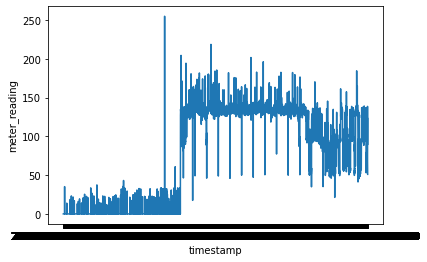

In [ ]:
# Hilangnya data 5 bulan pertama di beberapa gedung (Contoh : gedung 1, gedung 5, gedung 100) 
df3_1 = df3.loc[(df3.building_id == 1)]
sns.lineplot(x = 'timestamp', y = 'meter_reading', data = df3_1)

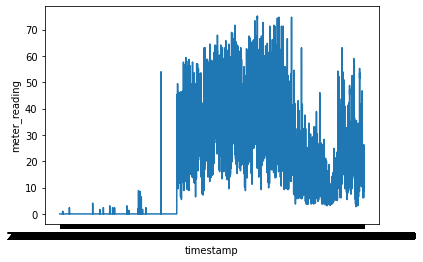

In [ ]:
df3_5 = df3.loc[(df3.building_id == 5)] 
sns.lineplot(x = 'timestamp', y = 'meter_reading', data = df3_5)

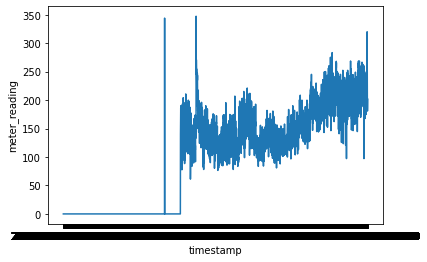

In [ ]:
df3_100 = df3.loc[(df3.building_id == 100)]
sns.lineplot(x = 'timestamp', y = 'meter_reading', data = df3_100)

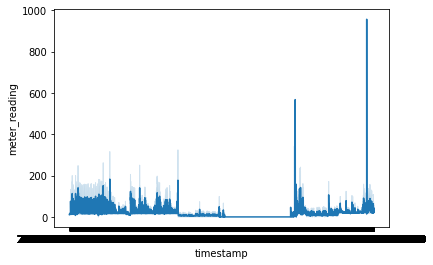

In [ ]:
# Hilangnya data di tengah-tengah tahun (Contoh : gedung 1012) 
df3_1012 = df3.loc[(df3.building_id == 1012)]
sns.lineplot(x = 'timestamp', y = 'meter_reading', data = df3_1012)

Karena tidak diketahui dengan pasti gedung berapa saja yang memiliki missing value di waktu apa saja, maka proses imputasi untuk missing value meter_reading harus dilakukan satu per satu. Proses tersebut cukup memakan waktu dan memori, karena ada lebih dari 1000 gedung, sehingga untuk saat ini akan dibiarkan saja. Jika memungkinkan, alangkah baiknya jika missing value pada meter_reading tersebut diimputasi satu per satu untuk meminimalkan bias yang mungkin terjadi.

# **Statistik Deskriptif, Visualisasi dan Insight Data**

In [31]:
# Statistik Deskriptif

df_total.describe()

,meter_reading,square_feet,air_temperature,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,month,natural_log
count,1.611948e+07,1.611948e+07,1.611948e+07,1.611948e+07,1.611948e+07,1.611948e+07,1.611948e+07,1.611948e+07,1.611948e+07,1.611948e+07,1.611948e+07
mean,1.122164e+02,7.372967e+04,1.665498e+01,8.275324e+00,7.795744e-01,1.016209e+03,1.715592e+02,3.266147e+00,1.144236e+01,6.590329e+00,3.662333e+00
std,1.405028e+02,5.874809e+04,1.024775e+01,9.569726e+00,7.281317e+00,6.294487e+00,1.123208e+02,2.082789e+00,6.934830e+00,3.388468e+00,1.824959e+00
min,0.000000e+00,2.830000e+02,-1.530000e+01,-2.010000e+01,-1.000000e+00,9.983000e+02,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
25%,1.365000e+01,2.603300e+04,9.400000e+00,1.100000e+00,0.000000e+00,1.011921e+03,8.000000e+01,2.100000e+00,5.000000e+00,4.000000e+00,2.684440e+00
50%,5.502000e+01,5.920000e+04,1.720000e+01,9.000000e+00,0.000000e+00,1.016200e+03,1.700000e+02,3.100000e+00,1.100000e+01,7.000000e+00,4.025709e+00
75%,1.550930e+02,1.051670e+05,2.440000e+01,1.610000e+01,0.000000e+00,1.020400e+03,2.700000e+02,4.600000e+00,1.700000e+01,1.000000e+01,5.050452e+00
max,6.425100e+02,2.529520e+05,4.440000e+01,2.610000e+01,3.430000e+02,1.034300e+03,3.600000e+02,9.300000e+00,2.300000e+01,1.200000e+01,6.466938e+00


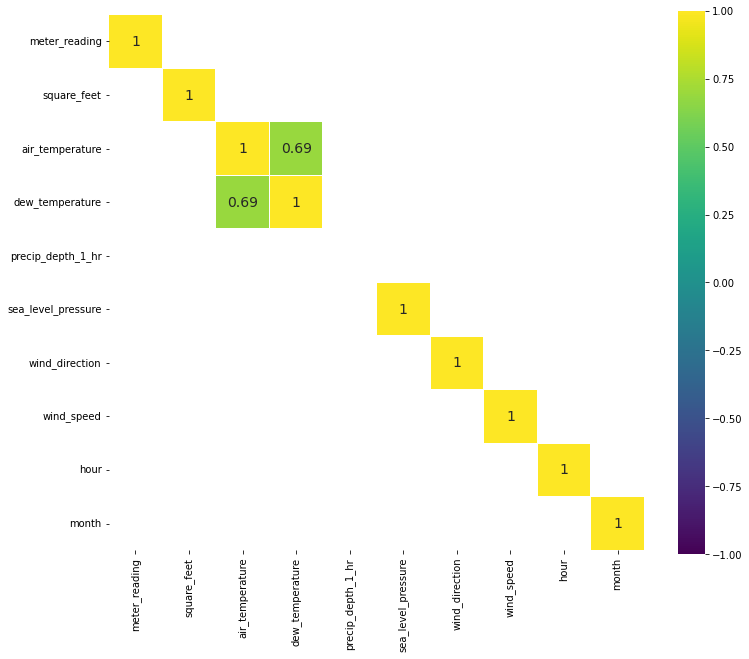

In [ ]:
# Cek korelasi

corr2 = df_total.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr2[(corr2 >= 0.5) | (corr2 <= -0.5)],
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 14}, square=True);

Dari plot di atas, dapat terlihat bahwa variabel air_temperature dan dew_temperature memiliki korelasi yang cukup kuat, yaitu 0.69. Ini mengindikasikan adanya multikolinearitas antara kedua variabel tersebut, yang perlu diperhatikan saat nanti hendak membuat model.

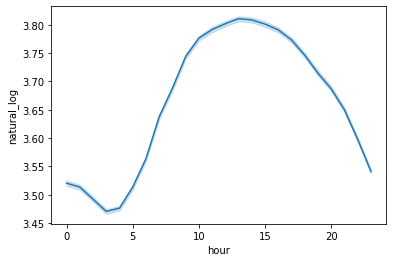

In [ ]:
# Melihat penggunaan energi per jam 

sns.lineplot(x = "hour", y = "natural_log", data = df_total)

Dari plot di atas, dapat dilihat bahwa ada kecenderungan rata-rata pemakaian energi naik mulai jam 5 pagi ke atas, dan mencapai puncaknya pada siang hari (sekitar pukul 11.00 sampai 15.00). Pemakaian energi cenderung menurun setelah melewati pukul 15.00, dan mencapai titik terendahnya pada pukul 3 dini hari.

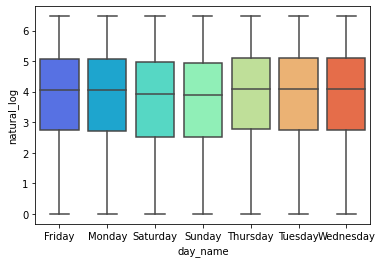

In [ ]:
# Penggunaan energi per hari dalam seminggu

sns.boxplot(x = 'day_name', y = 'natural_log', data = df_total, palette = 'rainbow')

Dari plot di atas, pemakaian energi pada hari sabtu dan minggu sedikit lebih rendah daripada hari-hari lainnya. Ini adalah hal yang wajar, mengingat sabtu dan minggu adalah *weekend* dan kebanyakan kantor/sekolah/institusi tidak beroperasi.

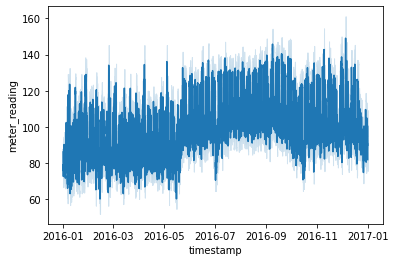

In [ ]:
# Melihat pemakaian energi untuk meter 0 (Electricity)

df_total.loc[(df_total.meter == 0)]
sns.lineplot(x = 'timestamp', y = 'meter_reading', data = df_total.loc[(df_total.meter == 0)])

Dari plot di atas diketahui bahwa pemakaian energi untuk listrik dari semua gedung pada 5 bulan pertama cenderung lebih rendah. Hal ini dicurigai disebabkan oleh banyaknya missing value pada 5 bulan pertama pada meter 0 (yang diketahui setelah menjalankan plot meter 0 untuk beberapa gedung).

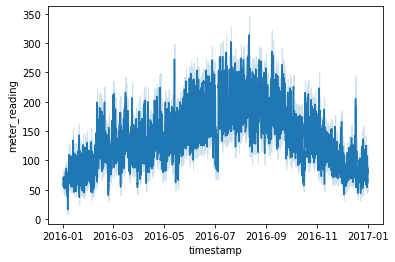

In [ ]:
# Melihat pemakaian energi untuk meter 1 (Chilled Water)

sns.lineplot(x = 'timestamp', y = 'meter_reading', data = df_total.loc[(df_total.meter == 1)])

Dari plot di atas, terlihat bahwa pemakaian energi tertinggi untuk air dingin (chilled water) kira-kira jatuh pada bulan 7 sampai 9. Bulan 7 sampai 9 merupakan musim panas di Amerika, sehingga wajar jika pemakaian air dingin meningkat. Pemakaian energi terendah ada pada bulan 12 sampai bulan 2. Bulan 12 sampai bulan 2 merupakan musim dingin di Amerika, sehingga air dingin tidak terlalu dibutuhkan.

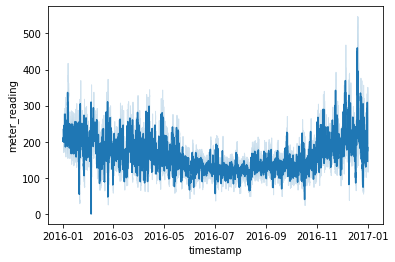

In [ ]:
# Melihat pemakaian energi untuk meter 2 (Steam)

sns.lineplot(x = 'timestamp', y = 'meter_reading', data = df_total.loc[(df_total.meter == 2)])

Jika dibandingkan dengan kedua plot sebelumnya, plot pertama berada di range 60 sampai 140, plot kedua berada di 50 sampai 250, sementara plot ketiga berada di range 100 sampai 300. Dengan demikian, pemakaian energi untuk steam cenderung lebih tinggi jika dibandingkan dengan listrik dan air dingin. Jika range pemakaian energi untuk air panas di bawah 100 sampai 300, maka steam memiliki kecenderungan untuk menjadi kebutuhan yang paling menghabiskan energi dari keempat jenis meter. Pemakaian energi yang tinggi ini kemungkinan disebabkan karena steam merupakan alat multifungsi yang biasa dipakai di gedung-gedung untuk menghangatkan atau mendinginkan udara, serta dapat digunakan pula untuk proses sterilisasi di rumah sakit dan pabrik-pabrik.  

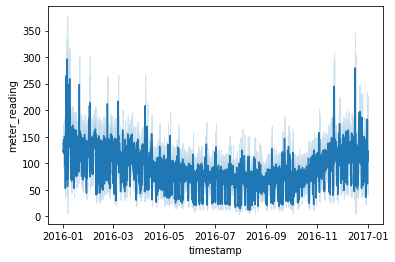

In [ ]:
# Melihat pemakaian energi untuk meter 3 (Hot Water)

sns.lineplot(x = 'timestamp', y = 'meter_reading', data = df_total.loc[(df_total.meter == 3)])

Dari plot di atas, dapat terlihat bahwa pemakaian energi untuk air panas pada bulan 11 sampai bulan 3 lebih tinggi daripada pemakaian energi untuk air panas pada bulan 5 sampai bulan 9. Kemungkinan besar ini disebabkan karena bulan 11 sampai dengan bulan 2 merupakan musim dingin di Amerika, sehingga pemakaian air panas meningkat. Begitu pula dengan bulan 7 sampai bulan 9 yang merupakan musim panas, sehingga pemakaian air panas pun menurun.

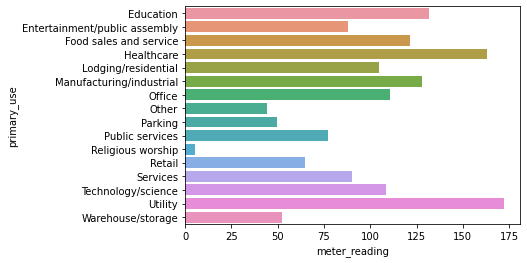

In [ ]:
# Menghitung rata-rata pemakaian energi per primary_use

df_primary_use = df_total.groupby('primary_use').aggregate({'meter_reading':np.mean})
df_primary_use.reset_index(inplace = True)
sns.barplot(x = 'meter_reading', y = 'primary_use', data = df_primary_use)

Religious worship atau tempat ibadah merupakan penggunaan gedung yang paling sedikit memakai energi, karena tempat ibadah tidak beroperasi setiap hari, hanya di hari-hari tertentu saja (misalnya gereja, tempat ibadah paling umum di Amerika, beroperasi secara aktif di hari Sabtu dan Minggu). 

Penggunaan gedung yang paling banyak memakai energi adalah utility (perusahaan air, gas, atau listrik), healthcare, education, food sales/service dan manufacturing/industrial (untuk proses produksi seperti pabrik). Gedung-gedung yang digunakan untuk kebutuhan tersebut merupakan gedung-gedung yang waktu aktifnya lama (misalnya rumah sakit beroperasi 24 jam, sekolah dan pabrik beroperasi dari pagi hingga sore, dan tempat makan bisa beroperasi sampai malam) sehingga tidak mengherankan jika pemakaian energinya lebih banyak daripada gedung yang digunakan untuk kebutuhan lain. 

Selain itu, gedung-gedung dengan penggunaan tersebut juga umumnya menggunakan steam, yang dicurigai merupakan penyebab pemakaian energi terbesar.

In [48]:
# Banyaknya data per site_id

df1['site_id'].value_counts()

3     274
13    154
2     135
15    124
9     124
0     105
14    102
4      91
5      89
8      70
1      51
6      44
12     36
10     30
7      15
11      5
Name: site_id, dtype: int64

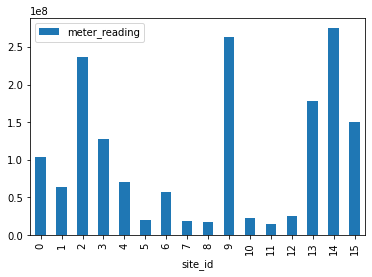

In [ ]:
# Pemakaian energi per site_id

df_total.groupby(['site_id']).aggregate({'meter_reading':np.sum}).plot(kind = 'bar')

Tempat yang lebih banyak mengonsumsi energi adalah tempat dengan kode site_id 2, 9, dan 14. Ketiga tempat tersebut memiliki >100 gedung, sehingga dicurgai merupakan daerah perkotaan. Keempat tempat lainnya yang memiliki gedung >100, yaitu site_id 13, 3, 15, dan 0, juga mengonsumsi energi relatif tinggi walaupun tidak setinggi ketiga tempat sebelumnya. Kemungkinan besar ketiga gedung sebelumnya berada di wilayah atau negara yang sama, karena perbedaan meter_reading yang cukup signifikan. Site 5, 7, 8, 10, 11, dan 12 mengonsumsi energi lebih sedikit dan memiliki jumlah gedung yang lebih sedikit pula, sehingga dicurigai wiliayah ini tidak terletak di pusat kota (mungkin pinggiran kota).

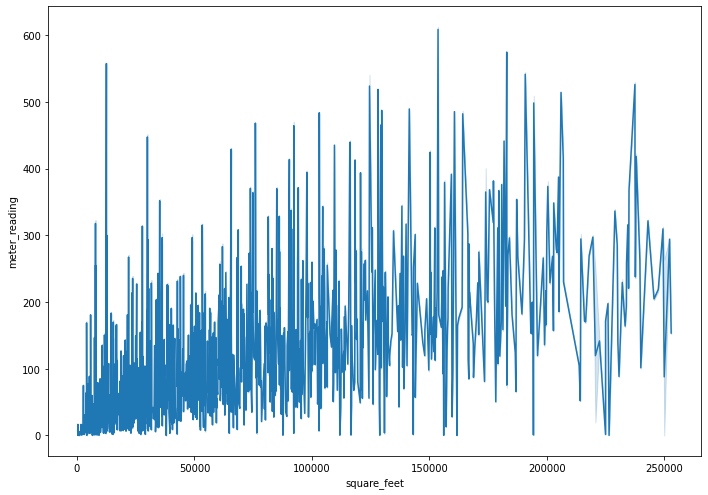

In [54]:
# Membuat plot meter_reading dan square_feet

sns.lineplot(x = 'square_feet', y = 'meter_reading', data = df_total)

Dari plot di atas, dapat terlihat bahwa pemakaian energi dan luas tanah kemungkinan berbanding lurus, karena semakin luas tanahnya, ada kecenderungan pemakaian energi juga naik. 

## **Kesimpulan**

*   Ada indikasi log(meter_reading) berdistribusi normal.
*   Ada indikasi multikolinearitas antara variabel air_temperature dan dew_temperature.
*   Pemakaian energi tertinggi cenderung terjadi pada siang hari (pukul 11.00 - 15.00) dan pemakaian energi terendah cenderung terjadi pada dini hari (pukul 3.00).
*   Pemakaian energi pada hari sabtu dan minggu (weekend) cenderung lebih rendah daripada hari lainnya, meskipun demikian perbedaannya tidak terlalu signifikan.
*   Pemakaian energi tertinggi secara umum digunakan untuk steam. 
*   Pemakaian energi untuk listrik pada 5 bulan pertama lebih rendah karena ada indikasi missing value.
*   Pemakaian energi untuk air dingin cenderung naik saat bulan 7 sampai bulan 9, dan cenderung turun saat bulan 12 sampai bulan 2. Kemungkinan hal tersebut disebabkan karena bulan 7 sampai bulan 9 merupakan musim panas, sementara bulan 12 sampai bulan 2 merupakan musim dingin.
*   Pemakaian energi untuk air panas cenderung naik saat bulan 11 sampai bulan 1, dan cenderung turun saat bulan 5 sampai bulan 9. Kemungkinan hal tersebut disebabkan karena bulan 5 sampai bulan 9 merupakan musim panas, sementara bulan 11 sampai bulan 1 merupakan musim dingin.
*   Gedung yang dipakai sebagai tempat ibadah memakan energi paling sedikit jika dibandingkan dengan yang lainnya, kemungkinan disebabkan oleh waktu aktif beroperasi yang lebih singkat (hanya hari-hari tertentu saja).
*   Gedung-gedung yang dipakai untuk utility (perusahaan air, gas, dan listrik), healthcare, education, food sales and service, serta manufacturing/industrial cenderung menggunakan energi lebih banyak, kemungkinan dikarenakan waktu aktif beroperasi yang cukup lama dan pemakaian steam yang cukup memakan energi.
*   Gedung-gedung yang terletak di wilayah site_id 2, 9, dan 14 mengonsumsi energi lebih banyak daripada wilayah lainnya dan memiliki gedung >100, relatif lebih banyak daripada wilayah lainnya. Kemungkinan tiga wilayah ini merupakan pusat kota.
*   Gedung-gedung yang terletak di wilayah site_id 5, 7, 8, 10, 11, dan 12 mengonsumsi energi lebih sedikit daripada wilayah lainnya dan memiliki gedung yang relatif lebih sedikit. Kemungkinan wilayah-wilayah ini adalah pinggiran kota.
*   Ada kecenderungan pemakaian energi berbanding lurus dengan luas bangunan.